# AIS Example

This example uses AIS data from a CSV file containing a full day of observations provided by the Danish Maritime Authority to show how to read, manage, and write information using PyMEOS.
It is divided in 3 sections, each corresponding to one MEOS example:
- [Reading from File](https://libmeos.org/tutorialprograms/meos_read_ais/)
- [Assembling Trips](https://libmeos.org/tutorialprograms/meos_assemble_ais/)
- [Storing in MobilityDB](https://libmeos.org/tutorialprograms/meos_store_ais/)

This example uses the plotting and database capabilities of PyMEOS. To get the necessary dependencies for this demo, you can run the following command:
```shell
pip install pymeos[dbp,plot] pandas tqdm contextily
```

If you don't have MobilityDB set up, you can use the Docker image:
```shell
docker run -d -p 5432:5432 --name pymeos-demo-db mobilitydb/mobilitydb:16-3.4-1.1-beta1
```

Note that due to its size, the data file used is not provided. It can be downloaded using the following URL:

[https://web.ais.dk/aisdata/aisdk-2023-08-01.zip](https://web.ais.dk/aisdata/aisdk-2023-08-01.zip)

Store the file in the [data](./data) directory. There is no need to decompress it, since we will use `pandas` to read the file and it supports reading compressed files.

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from pymeos import *
from tqdm.notebook import tqdm
import contextily as cx

tqdm.pandas()

pymeos_initialize()

## Reading from File ([MEOS Example](https://libmeos.org/tutorialprograms/meos_read_ais/))
In this section, AIS data is read from a CSV file. We then use the read information to recreate the trajectories of the ships.



First, let's read the CSV file using pandas. We will read only the columns we're interested in, and remove the observations that are either erroneous or not in Denmark.

In [13]:
%%time
ais = pd.read_csv(
    "./data/aisdk-2023-10-19.zip",
    usecols=["# Timestamp", "MMSI", "Latitude", "Longitude", "SOG"],
)
ais.columns = ["t", "mmsi", "lat", "lon", "sog"]
ais = ais[ais["t"] != 0]
ais["t"] = pd.to_datetime(ais["t"], format='%d/%m/%Y %H:%M:%S')
ais = ais[ais["mmsi"] != 0]
ais = ais.drop_duplicates(["t", "mmsi"])
ais = ais[(ais["lat"] >= 40.18) & (ais["lat"] <= 84.17)]
ais = ais[(ais["lon"] >= -16.1) & (ais["lon"] <= 32.88)]
ais = ais[(ais["sog"] >= 0) & (ais["sog"] <= 1022)]
ais.dropna()
ais.head()

CPU times: user 16.1 s, sys: 629 ms, total: 16.7 s
Wall time: 16.9 s


,t,mmsi,lat,lon,sog
0,2023-10-19,219029699,57.137907,9.127860,0.0
1,2023-10-19,219005827,56.803713,9.020183,0.0
2,2023-10-19,219006283,56.764315,8.863167,0.0
3,2023-10-19,220466000,56.970548,9.257460,0.1
4,2023-10-19,210731000,54.220680,11.386588,7.5


Now, we will create the PyMEOS object representing the position and the SOG.

In [14]:
ais["instant"] = ais.progress_apply(
    lambda row: TGeogPointInst(point=(row["lon"], row["lat"]), timestamp=row["t"]),
    axis=1,
)
ais["sog"] = ais.progress_apply(
    lambda row: TFloatInst(value=row["sog"], timestamp=row["t"]), axis=1
)

  0%|          | 0/8933109 [00:00<?, ?it/s]

  0%|          | 0/8933109 [00:00<?, ?it/s]

In [15]:
ais.drop(["lat", "lon"], axis=1, inplace=True)
ais.head()

,t,mmsi,sog,instant
0,2023-10-19,219029699,0@2023-10-19 00:00:00+02,POINT(9.12786 57.137907)@2023-10-19 00:00:00+02
1,2023-10-19,219005827,0@2023-10-19 00:00:00+02,POINT(9.020183 56.803713)@2023-10-19 00:00:00+02
2,2023-10-19,219006283,0@2023-10-19 00:00:00+02,POINT(8.863167 56.764315)@2023-10-19 00:00:00+02
3,2023-10-19,220466000,0.1@2023-10-19 00:00:00+02,POINT(9.25746 56.970548)@2023-10-19 00:00:00+02
4,2023-10-19,210731000,7.5@2023-10-19 00:00:00+02,POINT(11.386588 54.22068)@2023-10-19 00:00:00+02


## Assembling Trips ([MEOS Example](https://libmeos.org/tutorialprograms/meos_assemble_ais/))

Now, we will create the trajectory (TGeogPointSeq) and the SOG evolution (TFloatSeq) for every ship (identified by the mmsi) using the instants we have created.

In [16]:
%%time
trajectories = (
    ais.groupby("mmsi")
    .aggregate(
        {
            "instant": lambda x: TGeogPointSeq.from_instants(x, upper_inc=True),
            "sog": lambda x: TFloatSeq.from_instants(x, upper_inc=True),
        }
    )
    .rename({"instant": "trajectory"}, axis=1)
)
trajectories["distance"] = trajectories["trajectory"].apply(lambda t: t.length())
trajectories.head()

CPU times: user 32.1 s, sys: 188 ms, total: 32.3 s
Wall time: 32.3 s


,trajectory,sog,distance
mmsi,,,
2190045,[POINT(8.44805 55.464272)@2023-10-19 00:00:10+...,"[0@2023-10-19 00:00:10+02, 0.1@2023-10-19 00:0...",4196.237335
9109416,[POINT(9.785182 54.909655)@2023-10-19 05:21:13...,"[1.4@2023-10-19 05:21:13+02, 0.2@2023-10-19 05...",48.376014
111219504,[POINT(9.838743 57.103408)@2023-10-19 07:32:04...,"[0@2023-10-19 07:32:04+02, 0@2023-10-19 07:34:...",249300.505518
111219508,[POINT(12.121327 55.591252)@2023-10-19 11:52:4...,"[1.7@2023-10-19 11:52:43+02, 7.5@2023-10-19 11...",463414.183253
111219512,[POINT(9.286713 55.220503)@2023-10-19 09:44:07...,"[16.9@2023-10-19 09:44:07+02, 54.2@2023-10-19 ...",122854.298352


Here we can see that PyMEOS has been able to reduce the number of points stored (and thus memory used) without losing any information.

In [17]:
comparison = pd.concat(
    [
        ais.groupby("mmsi")["t"].count().rename("original #points"),
        trajectories["trajectory"]
        .apply(lambda t: t.num_instants())
        .rename("PyMEOS #points"),
    ],
    axis=1,
)
comparison["Points kept (%)"] = (
    comparison["PyMEOS #points"] / comparison["original #points"] * 100
)
comparison

,original #points,PyMEOS #points,Points kept (%)
mmsi,,,
2190045,8849,7180,81.139112
9109416,63,58,92.063492
111219504,3162,3058,96.710942
111219508,5830,5760,98.799314
111219512,799,773,96.745932
...,...,...,...
677064088,696,636,91.379310
826500702,370,286,77.297297
887222300,867,548,63.206459


We can visualize the trajectories and the SOG evolutions by plotting them. We will plot only 100 of the trajectories.

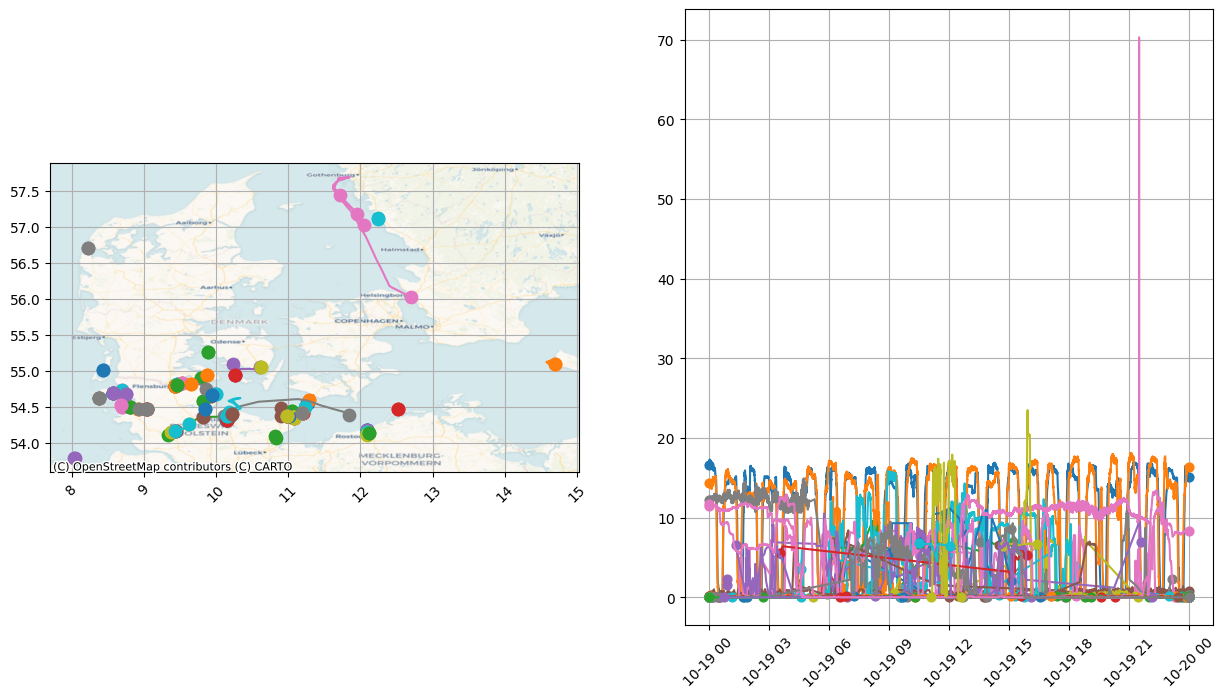

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
for _, ship in trajectories[100:200].iterrows():
    ship["trajectory"].plot(axes=axes[0])
    ship["sog"].plot(axes=axes[1])
cx.add_basemap(axes[0], crs=4326, source=cx.providers.CartoDB.Voyager)
plt.show()

## Storing in MobilityDB ([MEOS Example](https://libmeos.org/tutorialprograms/meos_store_ais/))

Now we will store the temporal objects we have created in MobilityDB.
To connect to MobilityDB (PostgreSQL), `psycopg` is used. However, `asyncpg` and `psycopg2` are also supported.

First, set up the connection parameters. Change any of the following values according to your configuration. If you are using the docker image, you don't need to change anything (except maybe the port).

In [19]:
from pymeos.db.psycopg import MobilityDB

host = "localhost"
port = 5432
db = "mobilitydb"
user = "docker"
password = "docker"

connection = MobilityDB.connect(
    host=host, port=port, dbname=db, user=user, password=password
)
cursor = connection.cursor()

OperationalError: connection failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?

Now, we will create the table where we will write our objects.

In [ ]:
cursor.execute("DROP TABLE IF EXISTS public.PyMEOS_demo;")
cursor.execute(
    "CREATE TABLE public.PyMEOS_demo"
    "(MMSI integer, trajectory public.tgeogpoint, SOG public.tfloat);"
)
connection.commit()

Let's insert now the rows of the DataFrame into the MobilityDB table. First, we'll create a SQL INSERT query with all the values, and then we will execute it in MobilityDB.

In [ ]:
query = "INSERT INTO public.PyMEOS_demo(MMSI, trajectory, SOG) VALUES"
for mmsi, row in trajectories.iterrows():
    query += f"\n({mmsi}, '{row.trajectory}', '{row.sog}'),"
query = query[:-1] + ";"

In [ ]:
%%time
cursor.execute(query)
connection.commit()

Let's check how many rows we just added

In [ ]:
cursor.execute("SELECT COUNT(*) FROM public.PyMEOS_demo;")
cursor.fetchone()[0]

Now, we will read one of the records that we just wrote

In [ ]:
cursor.execute("SELECT * FROM public.PyMEOS_demo WHERE MMSI = 97000050;")
mmsi, trajectory, sog = cursor.fetchone()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
trajectory.plot(axes=axes[0])
sog.plot(axes=axes[1])
plt.suptitle(f"Ship {mmsi}")
plt.show()

Finally, let's close the connection and wrap everything up

In [ ]:
connection.commit()
cursor.close()
pymeos_finalize()